# Model Testing

### Imports

In [4]:
import sys
import ast
import git
import numpy as np
import random
from tqdm.auto import tqdm, trange
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_BLOCKTIME'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [18]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Attention, Concatenate, Layer, Embedding, Dot, Softmax, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import LambdaCallback
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Add, TimeDistributed, Masking
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Flatten
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, TimeDistributed, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

### Setup of metadata

In [7]:
ALL_NODE_TYPES = []
ALL_NODE_INDEXES = []
i = 0
for name in dir(ast):
    if not name.startswith('_'):
        attr = getattr(ast, name)
        if isinstance(attr, type) and issubclass(attr, ast.AST):
            ALL_NODE_TYPES.append(name)
            ALL_NODE_INDEXES.append(i)
            i += 1

MAX_NODE_LOOKUP_NUM = len(ALL_NODE_TYPES)

### Helper Functions

In [8]:
def get_random_commit_shas(directory, n):
    # Open the Git repository
    repo = git.Repo(directory)

    # Get the SHA of the latest commit on the main branch
    latest_commit_sha = repo.head.commit.hexsha

    # Get the SHA of the first commit on the main branch
    first_commit_sha = repo.git.rev_list('--max-parents=0', 'main').splitlines()[0]

    # Create a list of all the commit SHAs on the main branch
    all_commit_shas = [commit.hexsha for commit in repo.iter_commits('main')]

    # Exclude the most recent and first ever commits from the list of possible random commit SHAs
    possible_commit_shas = [sha for sha in all_commit_shas if sha != latest_commit_sha and sha != first_commit_sha]

    # Create an array to store the commit shas
    commit_shas = []

    # Loop n times to generate n random commit shas
    for i in range(n):
        # Generate a random index within the range of possible commit SHAs
        random_index = random.randint(0, len(possible_commit_shas) - 1)

        # Get the commit SHA at the random index
        commit_sha = possible_commit_shas[random_index]

        # Append the commit SHA to the array
        commit_shas.append(commit_sha)

        # Remove the chosen commit SHA from the list of possible commit SHAs to avoid duplicates
        possible_commit_shas.remove(commit_sha)

    # Return the array of commit shas
    return commit_shas


In [9]:
class Commit:
    def __init__(self, sha, repo_path):
        self.sha = sha
        self.repo_path = repo_path
        self.parent = None
        self.author = None
        self.datetime = None
        self._populate_commit_info()

    def _populate_commit_info(self):
        repo = git.Repo(self.repo_path)
        commit = repo.commit(self.sha)
        self.parent = commit.parents[0].hexsha if commit.parents else None
        self.author = commit.author.name if commit.author else None
        self.datetime = datetime.fromtimestamp(commit.committed_date)
        
    def get_testing_y_label(self):
        files_changed = self.get_files_changed()
        sources_at_commit = [self.get_source_at_commit(filename) for filename in files_changed]
        sources_at_parent = [self.get_source_at_parent(filename) for filename in files_changed]        

        asts_commit = [self.source_to_ast(source) for source in sources_at_commit]
        asts_parent = [self.source_to_ast(source) for source in sources_at_parent]
        
        num_for_loops_commit = 0
        for ast_tree in asts_commit:
            if ast_tree == None:
                continue
            for node in ast.walk(ast_tree):
                if isinstance(node, ast.For):
                    num_for_loops_commit += 1

        num_for_loops_parent = 0
        for ast_tree in asts_parent:
            if ast_tree == None:
                continue
            for node in ast.walk(ast_tree):
                if isinstance(node, ast.For):
                    num_for_loops_parent += 1

        return 1 if num_for_loops_commit > num_for_loops_parent else 0
        
    def get_files_changed(self):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return [diff.a_path for diff in commit.diff(commit.parents[0]) if diff.a_path.endswith('.py')]
        except:
            return []

    def get_source_at_commit(self, file_name):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return commit.tree[file_name].data_stream.read().decode('utf-8')
        except:
            return ''

    def get_source_at_parent(self, file_name):
        try:
            repo = git.Repo(self.repo_path)
            commit = repo.commit(self.sha)
            return commit.parents[0].tree[file_name].data_stream.read().decode('utf-8')
        except:
            return ''

    def source_to_ast(self, source):
        try:
            return ast.parse(source)
        except:
            return None

    def get_paths(self, tree):
        try:
            paths = set()

            # Recursive function to explore the tree
            def explore(node, path):
                # Add current node to path
                path.append(type(node).__name__)

                # If the node has no children, it's a leaf node and the path is complete
                if not list(ast.iter_child_nodes(node)):
                    paths.add(tuple(path))
                else:
                    # Explore each child node recursively
                    for child in ast.iter_child_nodes(node):
                        explore(child, path)

                # Remove current node from path before returning
                path.pop()

            # Start exploring from the root node
            root = ast.parse("")
            explore(tree, [])

            return paths
        except:
            return set([])

    def ast_to_bag_of_contexts(self, ast_trees):
        paths = set()
        for tree in ast_trees:
            paths |= self.get_paths(tree)
        return paths

    def map_bag_of_contexts_to_id(self, bag_of_contexts, all_node_types):
        mapped_paths = []
        for path in bag_of_contexts:
            mapped_path = []
            for node in path:
                index = all_node_types.index(node)
                mapped_path.append(index + 1)
            mapped_paths.append(mapped_path)
        return mapped_paths

    def one_hot_encode(self, bag_of_contexts, max_node_lookup_num):
        one_hot_paths = []

        # Iterate over each row in the array
        for row in bag_of_contexts:
            # Create an empty list to hold the one-hot encodings for this row
            row_one_hot = []

            # Iterate over each element in the row
            for num in row:
                # Create an empty list to hold the one-hot encoding for this number
                num_one_hot = [0] * (max_node_lookup_num + 1)

                # Set the corresponding element to 1
                num_one_hot[int(num)] = 1

                # Add the one-hot encoding for this number to the row's list
                row_one_hot.append(num_one_hot)

            # Add the row's list of one-hot encodings to the main list
            one_hot_paths.append(row_one_hot)

        return one_hot_paths

    def pad_each_context(self, bag_of_contexts, set_path_length, max_node_lookup_num, one_hot=True):
        padded_one_hot_paths = []
        for path in bag_of_contexts:
            if one_hot:
                padded_path = [[0] * (max_node_lookup_num + 1)] * max(set_path_length - len(path), 0) + path[-set_path_length:]
            else:
                padded_path = [0] * max(set_path_length - len(path), 0) + path[-set_path_length:]
            padded_one_hot_paths.append(padded_path)
        return padded_one_hot_paths

    def to_raw_consumable_data(self, onehot=False, all_node_types=ALL_NODE_TYPES, max_node_lookup_num=MAX_NODE_LOOKUP_NUM, set_path_length=32):
        files_changed = self.get_files_changed()
        sources_at_commit = [self.get_source_at_commit(filename) for filename in files_changed]
        sources_at_parent = [self.get_source_at_parent(filename) for filename in files_changed]        

        asts_commit = [self.source_to_ast(source) for source in sources_at_commit]
        asts_parent = [self.source_to_ast(source) for source in sources_at_parent]
        
        contexts_commit = self.ast_to_bag_of_contexts(asts_commit)
        contexts_parent = self.ast_to_bag_of_contexts(asts_parent)

        contexts = list(contexts_commit.symmetric_difference(contexts_parent))

        
        contexts = self.map_bag_of_contexts_to_id(contexts, all_node_types)

        if(onehot):
            contexts = self.one_hot_encode(contexts, max_node_lookup_num)

        contexts = self.pad_each_context(contexts, set_path_length, max_node_lookup_num, one_hot=onehot)

        return contexts
    
    def to_padded_consumable_data(self, padded_length=256, onehot=False, all_node_types=ALL_NODE_TYPES, max_node_lookup_num=MAX_NODE_LOOKUP_NUM, set_path_length=32):
        consumable = self.to_raw_consumable_data(onehot=onehot, all_node_types=all_node_types, max_node_lookup_num=max_node_lookup_num, set_path_length=set_path_length)

        if(len(consumable) == padded_length):
            return consumable
        
        if(len(consumable) > padded_length):
            return random.sample(consumable, padded_length)
        
        if onehot:
            blank_path = [[0] * (max_node_lookup_num + 1)] * ([0] * set_path_length)
        else:
            blank_path = ([0] * set_path_length)
            
        return ([blank_path] * (padded_length - len(consumable)) + consumable)


### Data Configuration and Generation

In [10]:
#Set this to any git repo on your local
REPO_PATH = "/home/brennan/bot-radio-tempName"
DATA_SIZE = 128
EXAMPLE_SIZE = 256
CONTEXT_SIZE = 32
OUTPUT_SIZE = 512

COMMITS = [Commit(sha, REPO_PATH) for sha in tqdm(get_random_commit_shas(REPO_PATH, DATA_SIZE), desc="Mining random commit SHAs")]
X_train = [c.to_padded_consumable_data(padded_length=EXAMPLE_SIZE, onehot=False, set_path_length=CONTEXT_SIZE) for c in tqdm(COMMITS, desc="Converting commit diffs to padded consumable data")]
y_train = [c.get_testing_y_label() for c in tqdm(COMMITS, desc="Getting testing labels")]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Mining random commit SHAs:   0%|          | 0/128 [00:00<?, ?it/s]

Converting commit diffs to padded consumable data:   0%|          | 0/128 [00:00<?, ?it/s]

Getting testing labels:   0%|          | 0/128 [00:00<?, ?it/s]

In [21]:
class Model:
    def __init__(
        self,
        input_shape=(EXAMPLE_SIZE, CONTEXT_SIZE),
        example_size=EXAMPLE_SIZE,
        context_size=CONTEXT_SIZE,
        output_size=OUTPUT_SIZE,
        num_heads=4,
        key_dim=512,
        units=256,
        rate=0.2,
        activation_fn1='relu',
        activation_fn2='relu',
        activation_fn3='relu',
        optimizer='adam',
        loss_fn='mse'
    ):

        self.input_shape = input_shape
        self.example_size = example_size
        self.context_size = context_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.units = units
        self.output_size = output_size
        self.rate = rate
        self.activation_fn1 = activation_fn1
        self.activation_fn2 = activation_fn2
        self.activation_fn3 = activation_fn3
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.model = self.build_model()
    
    def build_model(self):
        # Create model
        inputs = Input(shape=self.input_shape)
        
        # Apply masking to ignore padded values
        masked_inputs = Masking()(inputs)

        # Self-attention layer
        self_attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(masked_inputs, masked_inputs)

        # Layer normalization
        normalized = LayerNormalization()(self_attention)

        # Feedforward layer
        feedforward = TimeDistributed(Dense(units=self.units, activation=self.activation_fn1))(normalized)

        # Global max pooling layer to produce a fixed-length output vector representation
        pooled = GlobalMaxPooling1D()(feedforward)

        # Dropout layer to prevent overfitting
        dropout = Dropout(rate=self.rate)(pooled)

        # Fixed length vector representation
        outputs = Dense(units=self.output_size, activation=self.activation_fn2)(dropout)

        # Outputs
        binary_classification = Dense(units=1, activation=self.activation_fn3)(outputs)

        # Define model
        model = tf.keras.Model(inputs=inputs, outputs=binary_classification)

        # Compile model
        model.compile(optimizer=self.optimizer, loss=self.loss_fn)
        
        return model
    
    def fit(self, X_train, y_train, epochs, batch_size):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    def predict_multiple(self, X_test):
        return self.model.predict(X_test)
    
    def predict(self, consumable_data):
        return self.predict_multiple([consumable_data])[0]
    
    def predict_commit(self, commit, onehot=False):
        return self.predict(commit.to_padded_consumable_data(padded_length=self.example_size, onehot=onehot, set_path_length=self.context_size))
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [22]:
model = Model()

In [13]:
model.fit(X_train=np.array(X_train), y_train=np.array(y_train), epochs=10, batch_size=32)

Epoch 1/10
4/4 [==============================] - 7s 1s/step - loss: 0.2505
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 0.2549
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 8/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 9/10
4/4 [==============================] - 5s 1s/step - loss: 0.2549
Epoch 10/10
4/4 [==============================] - 4s 979ms/step - loss: 0.2549


In [14]:
model.evaluate(X_test=np.array(X_test), y_test=np.array(y_test))

1/1 [==============================] - 1s 674ms/step - loss: 0.1154


0.11538461595773697

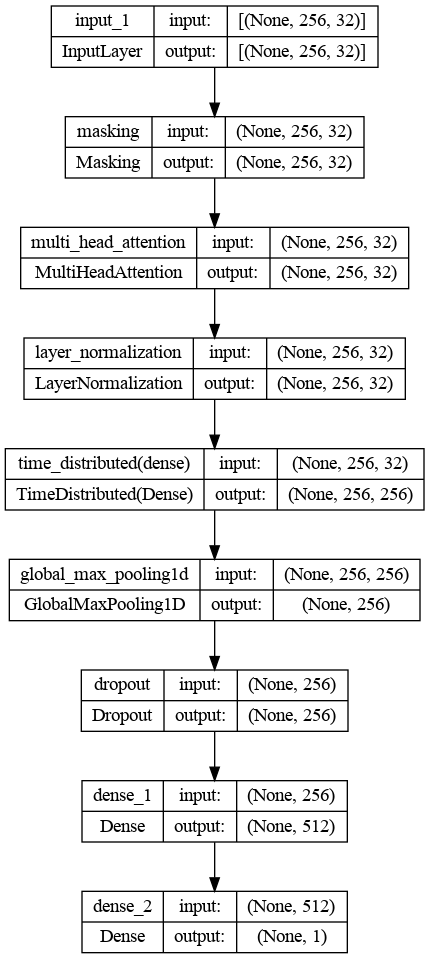

In [15]:
plot_model(model.model, show_shapes=True, show_layer_names=True)

#### Hyperparams

In [16]:
def experiment(X_train, X_test, y_train, y_test, param_name, param_values):
    default_params = {
        'input_shape': (EXAMPLE_SIZE, CONTEXT_SIZE),
        'example_size': EXAMPLE_SIZE,
        'context_size': CONTEXT_SIZE,
        'num_heads': 4, # Could also be 8
        'key_dim': 512, # Could also be 64
        'units': 256,
        'output_size': OUTPUT_SIZE,
        'rate': 0.2, # Could also be 0.01
        'activation_fn1': 'relu', # Could also be tanh
        'activation_fn2': 'relu', #Could also be tanh
        'activation_fn3': 'relu', #Could also be tanh
        'optimizer': 'adam',
        'loss_fn': 'mse'
    }

    # Initialize lists to store the results
    train_losses = []
    test_losses = []

    # Loop over the parameter values and train the model for each value
    for param_value in tqdm(param_values, desc="Training Models"):
        # Build the parameter dictionary
        params = default_params.copy()
        params[param_name] = param_value

        # Create the model
        model = Model(**params)

        # Train the model
        history = model.model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        # Save the training and test loss for this value of the parameter
        train_losses.append(history.history['loss'][-1])
        test_losses.append(history.history['val_loss'][-1])

    # Plot the results
    plt.plot(param_values, train_losses, label='Training Loss')
    plt.plot(param_values, test_losses, label='Test Loss')
    plt.xlabel(param_name)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

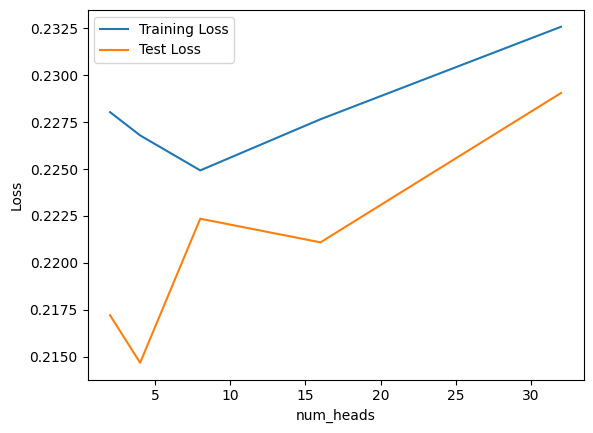

In [39]:
param_name = 'num_heads'
param_values = [2, 4, 8, 16, 32]
experiment(X_train, X_test, y_train, y_test, param_name, param_values)

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

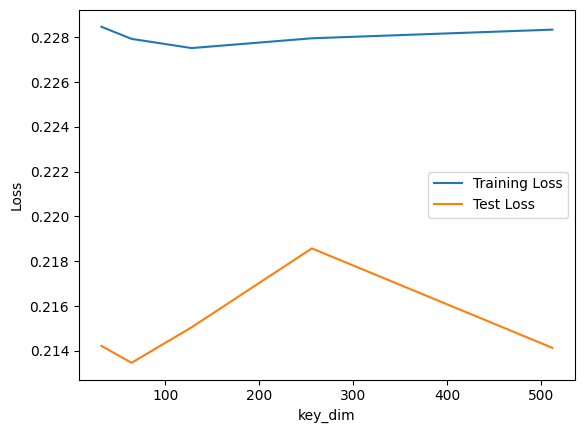

In [41]:
param_name = 'key_dim'
param_values = [32, 64, 128, 256, 512]
experiment(X_train, X_test, y_train, y_test, param_name, param_values)

Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

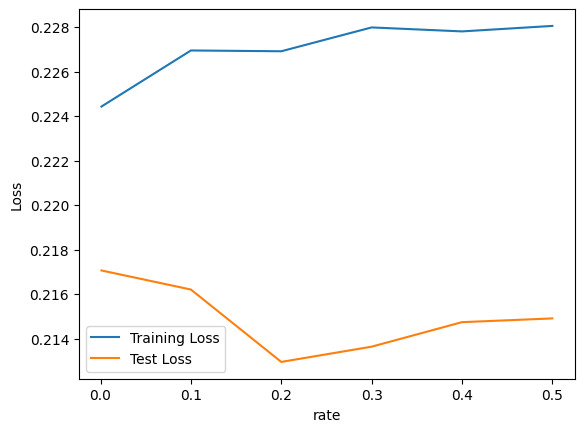

In [42]:
param_name = 'rate'
param_values = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]
experiment(X_train, X_test, y_train, y_test, param_name, param_values)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

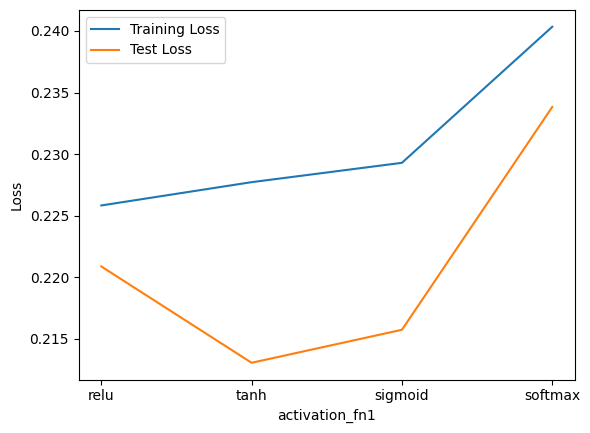

In [43]:
param_name = 'activation_fn1'
param_values = ['relu', 'tanh', 'sigmoid', 'softmax']
experiment(X_train, X_test, y_train, y_test, param_name, param_values)

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

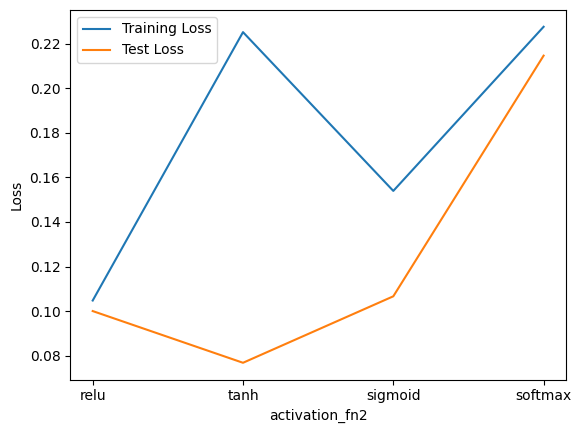

In [44]:
param_name = 'activation_fn2'
param_values = ['relu', 'tanh', 'sigmoid', 'softmax']
experiment(X_train, X_test, y_train, y_test, param_name, param_values)


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

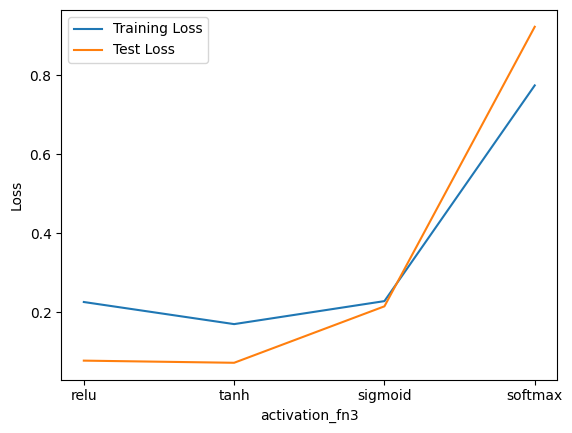

In [45]:
param_name = 'activation_fn3'
param_values = ['relu', 'tanh', 'sigmoid', 'softmax']
experiment(X_train, X_test, y_train, y_test, param_name, param_values)


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

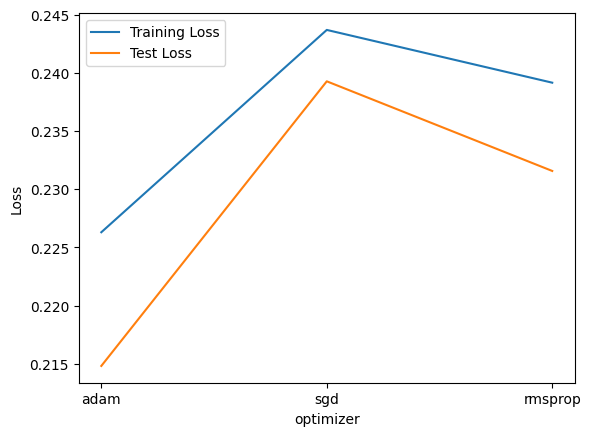

In [ ]:
param_name = 'optimizer'
param_values = ['adam', 'sgd', 'rmsprop']
experiment(X_train, X_test, y_train, y_test, param_name, param_values)


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

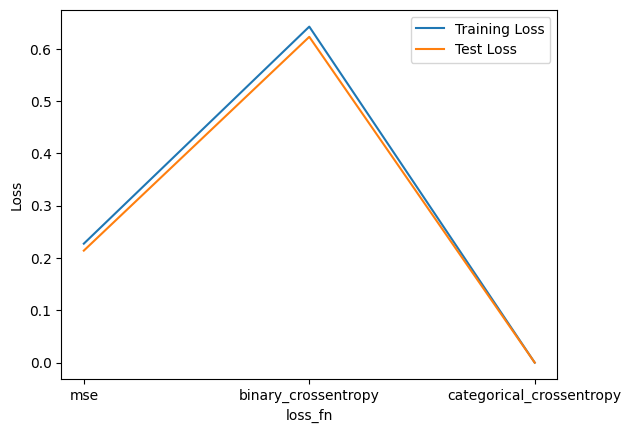

In [54]:
param_name = 'loss_fn'
param_values = ['mse', 'binary_crossentropy', 'categorical_crossentropy']
experiment(X_train, X_test, y_train, y_test, param_name, param_values)
